In [19]:
import json
import orjson
import xarray as xr
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import re
from datetime import datetime

from grid_and_bathy import MitgcmGrid, get_grid
from configs.config_object import ConfigObject

In [3]:
config = ConfigObject('../config.json')

In [4]:
path_grid = config.paths.grid_folder_path
output_folder = './output/binary_data/'
grid_resolution = config.grid_resolution
weather_model=config.weather_model
start_date=config.start_date
end_date=config.end_date
weather_model_type=config.weather_model_type

path_out = os.path.join(output_folder, rf'input_mitgcm_{weather_model}_{start_date}_{end_date}_{grid_resolution}m')

In [5]:
if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory '{path_out}' created.")
else:
    print(f"Directory '{path_out}' already exists.")

Directory './output/binary_data/input_mitgcm_continuous_reanalysis_20240501_20240503_1000m' already exists.


In [6]:
path_weather_folder = config.paths.raw_weather_folder
weather_model_type = config.weather_model_type

In [7]:
def write_binary(path_fname,data):
    '''
    Saves data in the right binary format for MITgcm, in the dimension order XYT
    Output binary files have been read and tested 
    '''

    data = data.to_numpy() #convert to xarray to numpy first - and then save to binary
    dtype = '>f8'  # big-endian and precision 64 (small-endian with precision 32 is '<f4')
    data = data.astype(dtype)

    # Write to file
    fid = open(path_fname, 'wb')
    data.tofile(fid)
    fid.close()

In [8]:
def load_json(file_path: str) -> dict:
    with open(file_path, "rb") as file:
        return orjson.loads(file.read())

In [9]:
def extract_data_from_json(json_data: dict, json_path: str, data_type: str) -> np.array:
    # Handle possible different data structures
    if data_type in json_data:
        data = np.array(json_data[data_type]["data"])
    elif "variables" in json_data and data_type in json_data["variables"]:
        data = np.array(json_data["variables"][data_type]["data"])
    else:
        raise KeyError(f"Data type '{data_type}' not found in JSON {json_path}.")

    return data

In [10]:
def select_first_24h(parsed_times: np.array(datetime), data: np.array):
    start_time = parsed_times[0]  # Assuming times are sorted
    end_time = start_time + pd.Timedelta(hours=24)
    valid_indices = (parsed_times >= start_time) & (parsed_times < end_time)

    parsed_times = parsed_times[valid_indices]  # Filter timestamps
    data = data[valid_indices]  # Filter data

    return parsed_times, data

In [11]:
def interp_to_grid(json_file: str, data_type: str, mitgcm_grid: MitgcmGrid):
    # Load JSON data once with orjson
    json_data = load_json(json_file)

    # Extract timestamps and convert to datetime
    parsed_times = pd.to_datetime(
        np.array(json_data).item().get('time')
        ).tz_localize(None)

    # Extract latitude and longitude
    lat, lon = np.array(json_data['lat']), np.array(json_data['lng'])
    coord_raw_data = np.column_stack((lat.flatten(), lon.flatten()))

    data = extract_data_from_json(json_data, json_file, data_type)
    filtered_parsed_times, filtered_data = select_first_24h(parsed_times, data)

    # Interpolate over all time steps (first 24h)
    data_interp = [
        xr.DataArray(
            griddata(coord_raw_data, filtered_data[i].flatten(),
                     (mitgcm_grid.lat_grid, mitgcm_grid.lon_grid),
                     method="linear"),
            dims=["Y", "X"],
            coords={"X": mitgcm_grid.x, "Y": mitgcm_grid.y, "T": time_i}
        )
        for i, time_i in enumerate(filtered_parsed_times)
    ]

    return xr.concat(data_interp, dim="T").sortby("T")

In [12]:
def filter_json_files_by_date(all_json_files: list[str], str_start_date: str, str_end_date: str) -> list[str]:
    start_date = datetime.strptime(str_start_date, '%Y%m%d')
    end_date = datetime.strptime(str_end_date, '%Y%m%d')

    def is_within_range(file):
        json_dates = re.findall(r'\d{8}', file)
        start_date_json = datetime.strptime(json_dates[0], '%Y%m%d')
        end_date_json = datetime.strptime(json_dates[1], '%Y%m%d')
        return (start_date_json >= start_date) & (start_date_json <= end_date) & (end_date_json >= start_date)

    return list(filter(is_within_range, all_json_files))

In [13]:
def interp_concat_json(folder_json_path, data_type, str_start_date, str_end_date, mitgcm_grid, parallel_n,
                       weather_model_type=""):
    all_json_files = glob.glob(os.path.join(folder_json_path, f'*_{data_type}.json'))
    json_files = filter_json_files_by_date(all_json_files, str_start_date, str_end_date)

    if weather_model_type == "forecast":
        data_type += "_MEAN"
    
    all_data=[]
    for file in json_files:
        all_data.append(interp_to_grid(file, data_type, mitgcm_grid))

    all_data = xr.concat(all_data, dim='T').sortby('T')

    unique_values, unique_ind = np.unique(all_data['T'].values, return_index=True)
    all_data_cleaned = all_data.isel(T=np.sort(unique_ind))

    parsed_start_date = pd.to_datetime(str_start_date, format="%Y%m%d")
    parsed_end_date = pd.to_datetime(str_end_date, format="%Y%m%d")
    datetime_list = pd.date_range(start=parsed_start_date, end=parsed_end_date, freq="h").to_list()
    interp_data = all_data_cleaned.interp({'T': datetime_list})  # make sure that time is consistent

    return interp_data.transpose('T', 'Y', 'X')

### Load grid for MITgcm

In [14]:
json_files = glob.glob(os.path.join(path_weather_folder, f'*.json'))
with open(json_files[0], "r") as file:
    data = json.load(file)
    time = np.array(data).item().get('time')
    lat = np.array(data['lat'])
    lon = np.array(data['lng'])

In [15]:
x = np.load(os.path.join(path_grid, 'x.npy'))
y = np.load(os.path.join(path_grid, 'y.npy'))

lat_grid = np.load(os.path.join(path_grid, 'lat_grid.npy'))
lon_grid = np.load(os.path.join(path_grid, 'lon_grid.npy'))

In [16]:
mitgcm_grid = get_grid(path_grid)

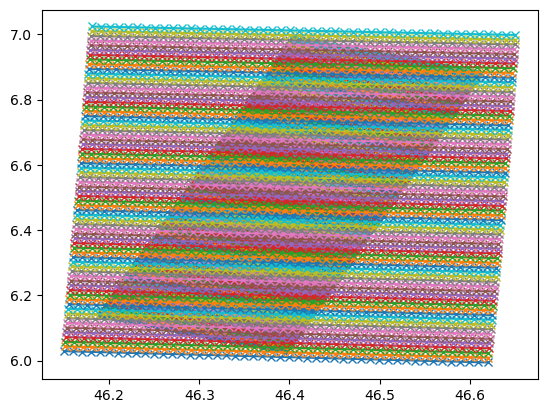

In [17]:
# grid mitgcm
plt.plot(lat_grid, lon_grid, marker='o')
# grid_icon
plt.plot(lat, lon, marker='x')

### Winds
- only interpolate onto model grid
- input for winds will be uwind and vwind; as opposed to ustress and vstress
- for formula for wind stress - check Wuest and Locke


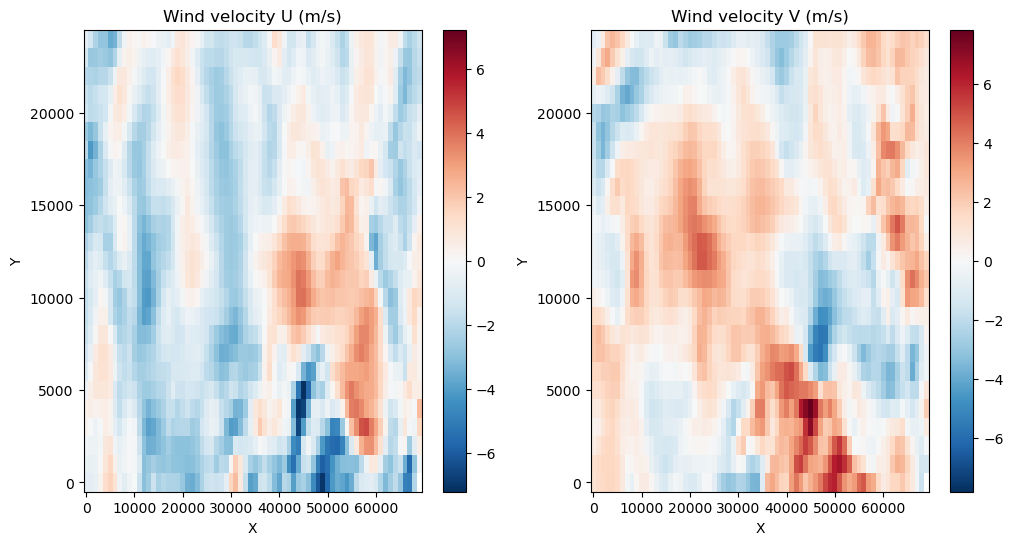

In [25]:
u10 = interp_concat_json(path_weather_folder,'U', start_date, end_date, mitgcm_grid, 1, weather_model_type)
v10 = interp_concat_json(path_weather_folder,'V', start_date, end_date, mitgcm_grid, 1, weather_model_type)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
u10.isel(T=0).plot(ax=ax1)
v10.isel(T=0).plot(ax=ax2)
ax1.set_title('Wind velocity U (m/s)')
ax2.set_title('Wind velocity V (m/s)')

write_binary(os.path.join(path_out, 'u10.bin'),u10)
write_binary(os.path.join(path_out, 'v10.bin'),v10)

### Air temp (should be in kelvin)
- units already in K


In [21]:
folder_json_path=path_weather_folder
data_type='T_2M'
str_start_date=start_date
str_end_date=end_date

In [22]:
all_json_files = glob.glob(os.path.join(folder_json_path, f'*_{data_type}.json'))
json_files = filter_json_files_by_date(all_json_files, str_start_date, str_end_date)

all_data = []

if weather_model_type == "forecast":
    data_type = data_type + "_MEAN"


In [23]:
for file in json_files:
    data = interp_to_grid(file, data_type, mitgcm_grid)
    all_data.append(data)

In [14]:
all_data_conc = xr.concat(all_data, dim='T').sortby('T')

# remove duplicate values - review download from COSMO
unique_values, unique_ind = np.unique(all_data_conc['T'].values, return_index=True)
unique_ind_sorted = np.sort(unique_ind)
all_data_cleaned = all_data_conc.isel(T=unique_ind_sorted)

# binary file for MITgcm should be in XYT
all_data_transposed = all_data_cleaned.transpose('T', 'Y', 'X')

ValueError: must supply at least one object to concatenate

In [15]:
all_data_conc['T'].values

NameError: name 'all_data_conc' is not defined

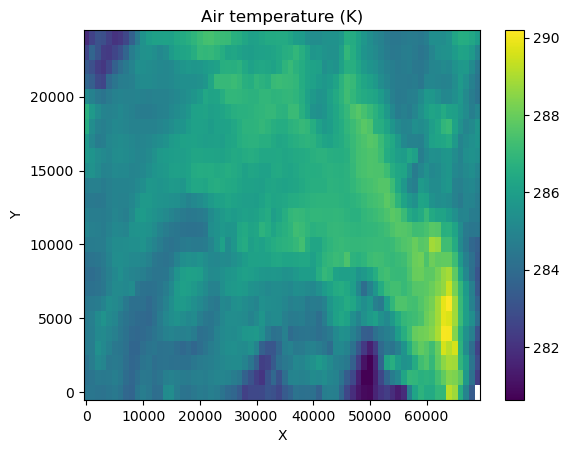

In [24]:
atemp = interp_concat_json(path_weather_folder,'T_2M', start_date, end_date, mitgcm_grid, 1, weather_model_type)
atemp.isel(T=0).plot()
plt.title('Air temperature (K)')

write_binary(os.path.join(path_out, 'atemp.bin'),atemp)

### Surface pressure (should be in Pa)
- units are N/m2, which is equivalent to Pa
- not sure if i should use pressure at mean sea level (and altitude height and temperature) to compute surface pressure 

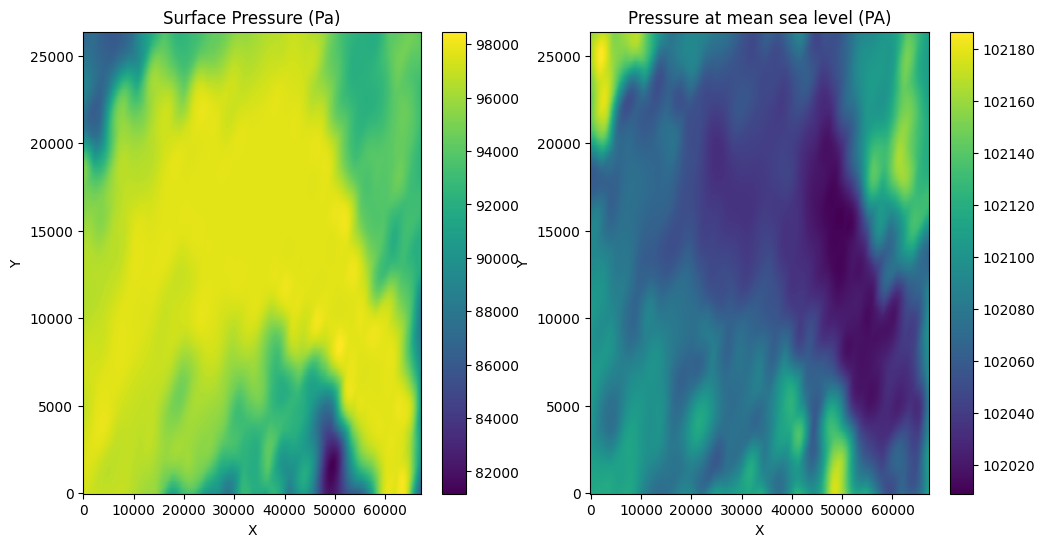

In [15]:
apress = interp_concat_json(path_weather_folder,'PS', start_date, end_date, lat_grid, lon_grid, weather_model_type)
pmsl =  interp_concat_json(path_weather_folder,'PMSL', start_date, end_date, lat_grid, lon_grid, weather_model_type)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
apress.isel(T=0).plot(ax=ax1)
ax1.set_title('Surface Pressure (Pa)')

pmsl.isel(T=0).plot(ax=ax2)
ax2.set_title('Pressure at mean sea level (PA)')

write_binary(os.path.join(path_out, 'apressure.bin'),apress)

### Surface specific humidity (should be in kg/kg)
- cosmo yields the relative humidity at 2m
- computes from temperature and relative humidity
- values seem too small - review formula 

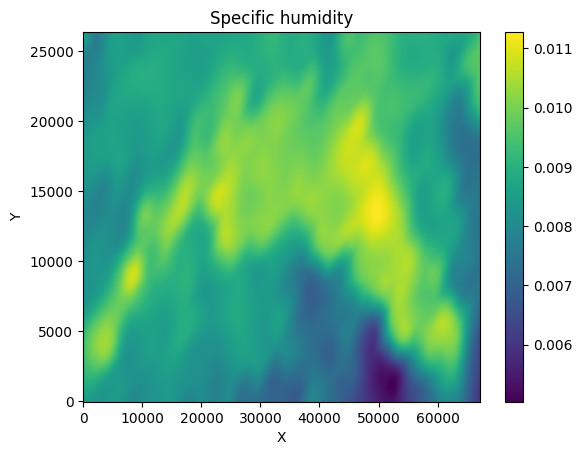

In [16]:
def calculate_specific_humidity(temp, relhum, atm_press):

    #temp needs to be in celcius
    temp = temp - 273.15
    
    # atmospheric pressure should be in hPa
    atm_press = atm_press / 100.0

    #saturation vapour pressure (e_s)
    e_s = 6.112 * np.exp((17.67 * temp) / (temp + 243.5))
    
    #actual vapour pressure (e)
    e = (relhum / 100) * e_s
    
    # Step 3: Calculate the specific humidity (q)
    q = (0.622 * e) / (atm_press - (0.378 * e))

    return (q)


relhum = interp_concat_json(path_weather_folder,'RELHUM_2M', start_date, end_date, lat_grid, lon_grid, weather_model_type)
aqh = calculate_specific_humidity(atemp, relhum, apress)

aqh.isel(T=0).plot()
plt.title('Specific humidity')

write_binary(os.path.join(path_out, 'aqh.bin'),aqh)
 

### Downward short wave radiation (should be in W/m2)

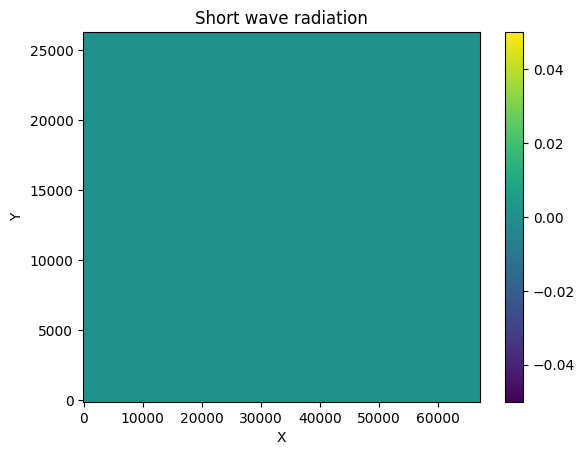

In [41]:
swr = interp_concat_json(path_weather_folder,'GLOB', start_date, end_date, lat_grid, lon_grid, weather_model_type)
swr.isel(T=0).plot()
plt.title('Short wave radiation')

filled_swr = swr.fillna(0)
write_binary(os.path.join(path_out, 'swdown.bin'),filled_swr)


In [42]:
path_out

'./output/binary_data/input_mitgcm_cosmo_20231201_20231202_200m'

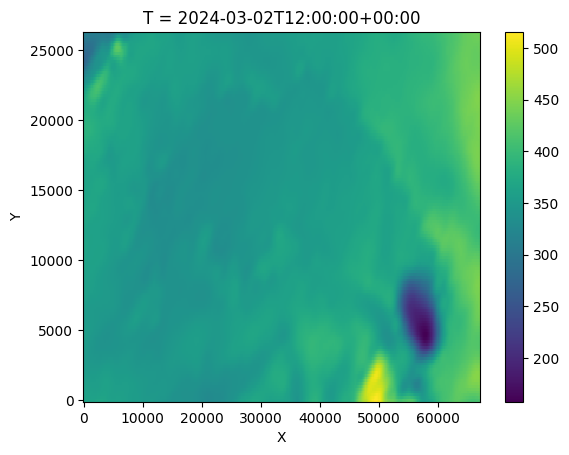

In [26]:
filled_swr.isel(T=36).plot()

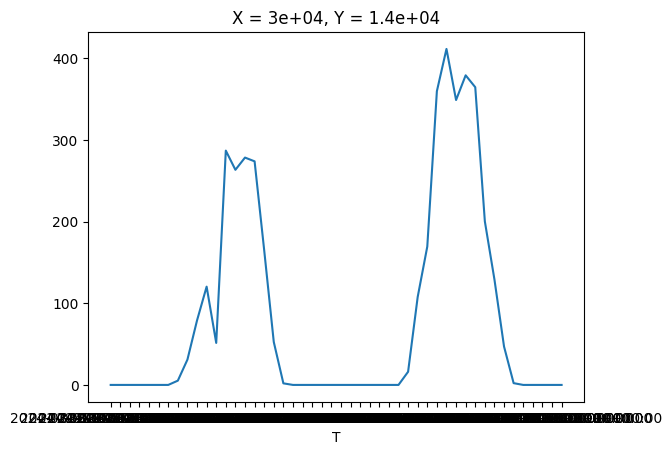

In [27]:
filled_swr.isel(X=150, Y=70).plot()

### Long wave radiation (in W/m2)
- computed from air temperature and cloud cover
- cloud cover is originally in % -  should range from 0 to 1  

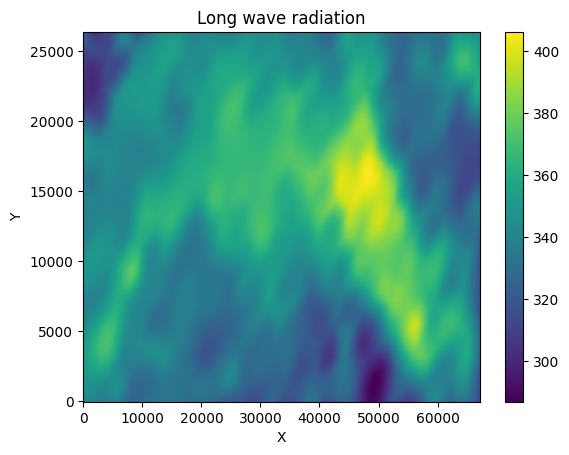

In [46]:
def compute_longwave_radiation(atemp, cloud_cover):
    """
    Compute longwave radiation from air temperature and cloud cover.

    - temp: Air temperature in Kelvin 
    - cloud_cover: %
    """
    # cloud cover should be from 0 to 1 
    cloud_cover = cloud_cover/100
    cloud_cover = cloud_cover.where(cloud_cover > 0,0)
    vaporPressure = 6.11 * np.exp(17.67 * (atemp-273.15) / (atemp-29.65)) # in units of hPa
    A_L = 0.03   # Infrared radiation albedo
    a = 1.09     # Calibration parameter
    E_a = a * (1 + 0.17 * np.power(cloud_cover, 2)) * 1.24 * np.power(vaporPressure / atemp, 1./7)
    lwr = (1 - A_L) * 5.67e-8 * E_a * np.power(atemp, 4)
    return lwr

CLCT = interp_concat_json(path_weather_folder,'CLCT', start_date, end_date, lat_grid, lon_grid, weather_model_type)
lwr = compute_longwave_radiation(atemp, CLCT)
lwr.isel(T=0).plot()
plt.title('Long wave radiation')

write_binary(os.path.join(path_out, 'lwdown.bin'),lwr)